# Deep Learning - Better Model Training in PyTorch
---

## Author : Amir Atapour-Abarghouei, amir.atapour-abarghouei@durham.ac.uk

This notebook will provide an example that shows how model performance can be improved in PyTorch.

Copyright (c) 2024 Amir Atapour-Abarghouei, UK.

License : LGPL - http://www.gnu.org/licenses/lgpl.html

We are going to use a simple network to show how good performance can be reached. Let's start by importing what we need:

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


Let's import the dataset first. We will use the FashionMNIST dataset:

In [2]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Load the CIFAR-10 dataset
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
    batch_size=64, drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
    batch_size=64, drop_last=True
)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'Size of training dataset: {len(train_loader.dataset)}')
print(f'Size of test dataset: {len(test_loader.dataset)}')

Files already downloaded and verified
Files already downloaded and verified
Size of training dataset: 50000
Size of test dataset: 10000


Here, we will view some of the test dataset images:

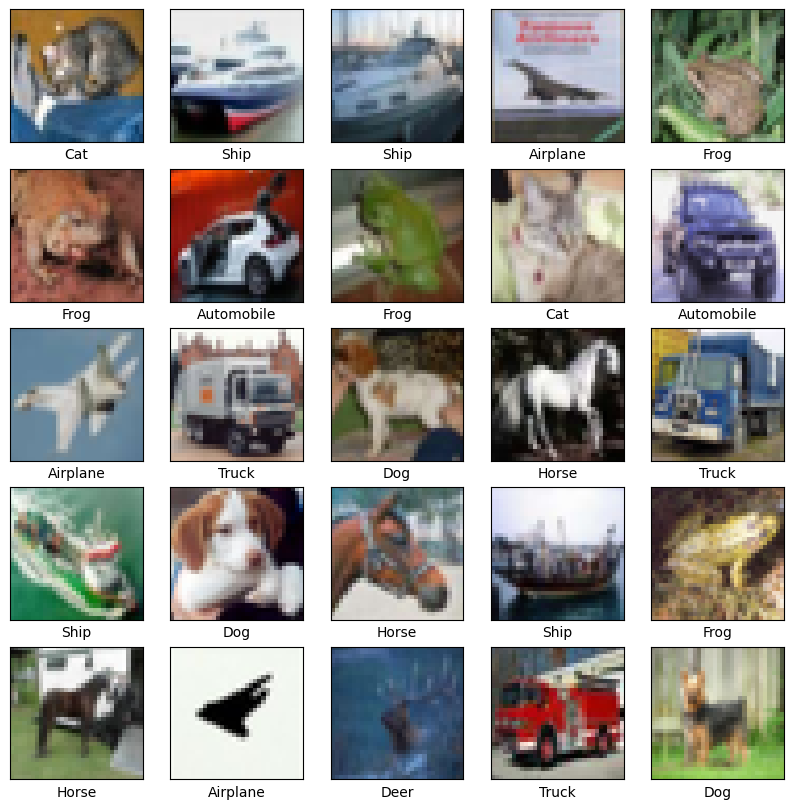

In [3]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_loader.dataset[i][0].permute(1, 2, 0), cmap=plt.cm.binary)
    plt.xlabel(class_names[test_loader.dataset[i][1]])

Now, let's create a simple convolutional model:

In [4]:
# define the model
class ConvNetwork(nn.Module):
    def __init__(self):
        super(ConvNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Conv2d(in_channels=64, out_channels=10, kernel_size=4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.fc(x)
        return x.view(x.size(0), -1)

# create the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N = ConvNetwork().to(device)

# print the number of model parameters
print(f'Number of model parameters is: {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

# initialise the optimiser
optimiser = torch.optim.Adam(N.parameters(), lr=0.001)
epoch = 0

Number of model parameters is: 44650


**Main training and testing loop**

In [5]:
epoch = 0
while epoch < 5:
    N.train()  # Set the model to training mode

    # arrays for metrics
    train_loss_arr = np.zeros(0)
    train_acc_arr = np.zeros(0)
    test_acc_arr = np.zeros(0)

    # iterate over some of the train dataset
    for i in range(1000):
        x, t = next(train_iterator)
        x, t = x.to(device), t.to(device)

        optimiser.zero_grad()
        p = N(x)
        pred = p.argmax(dim=1, keepdim=True)
        loss = torch.nn.functional.cross_entropy(p, t)
        loss.backward()
        optimiser.step()

        train_loss_arr = np.append(train_loss_arr, loss.cpu().data)
        train_acc_arr = np.append(train_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    print('train loss: {:.3f}, train acc: {:.3f}'.format(train_loss_arr.mean(), train_acc_arr.mean()))

    epoch += 1

# Evaluation phase
N.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient computation
    for x, t in test_loader:
        x, t = x.to(device), t.to(device)
        p = N(x)
        pred = p.argmax(dim=1, keepdim=True)
        test_acc_arr = np.append(test_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

print('* Test Accuracy [with just a conv]: {:.3f}'.format(test_acc_arr.mean()))

train loss: 2.710, train acc: 0.161
train loss: 2.523, train acc: 0.206
train loss: 2.462, train acc: 0.222
train loss: 2.423, train acc: 0.232
train loss: 2.393, train acc: 0.243
* Test Accuracy [with just a conv]: 0.244


Let's see if we can make the architecture better. We will add batchnorm and some dropout.

In [6]:
# define the model
class BetterConvNetwork(nn.Module):
    def __init__(self):
        super(BetterConvNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Conv2d(in_channels=64, out_channels=10, kernel_size=4)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.fc(x)
        return x.view(x.size(0), -1)

# create the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N = BetterConvNetwork().to(device)

# print the number of model parameters
print(f'Number of model parameters is: {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

# initialise the optimiser
optimiser = torch.optim.Adam(N.parameters(), lr=0.001)
epoch = 0

Number of model parameters is: 44842


Now let's add some augmentation:

In [7]:
# Helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Define transformations with augmentation for the training set
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    torchvision.transforms.ToTensor()
])

# For the test set, only normalize the data (no augmentations)
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# Load the CIFAR-10 dataset with the transformations
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('data', train=True, download=True, transform=train_transform),
    batch_size=64, drop_last=True, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('data', train=False, download=True, transform=test_transform),
    batch_size=64, drop_last=True, shuffle=False
)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'Size of training dataset: {len(train_loader.dataset)}')
print(f'Size of test dataset: {len(test_loader.dataset)}')


Files already downloaded and verified
Files already downloaded and verified
Size of training dataset: 50000
Size of test dataset: 10000


Now let's train again to see if we got any improvement:

In [9]:
epoch = 0
while epoch < 5:
    N.train()  # Set the model to training mode

    # arrays for metrics
    train_loss_arr = np.zeros(0)
    train_acc_arr = np.zeros(0)
    test_acc_arr = np.zeros(0)

    # iterate over some of the train dataset
    for i in range(1000):
        x, t = next(train_iterator)
        x, t = x.to(device), t.to(device)

        optimiser.zero_grad()
        p = N(x)
        pred = p.argmax(dim=1, keepdim=True)
        loss = torch.nn.functional.cross_entropy(p, t)
        loss.backward()
        optimiser.step()

        train_loss_arr = np.append(train_loss_arr, loss.cpu().data)
        train_acc_arr = np.append(train_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    print('train loss: {:.3f}, train acc: {:.3f}'.format(train_loss_arr.mean(), train_acc_arr.mean()))

    epoch += 1

# Evaluation phase
N.eval()

with torch.no_grad():
    for x, t in test_loader:
        x, t = x.to(device), t.to(device)
        p = N(x)
        pred = p.argmax(dim=1, keepdim=True)
        test_acc_arr = np.append(test_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

print('* Test Accuracy [with improvements and augmentations] : {:.3f}'.format(test_acc_arr.mean()))


train loss: 2.267, train acc: 0.283
train loss: 2.242, train acc: 0.292
train loss: 2.225, train acc: 0.299
train loss: 2.202, train acc: 0.305
train loss: 2.191, train acc: 0.308
* Test Accuracy [with improvements and augmentations] : 0.283
